Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [544]:
NAME = "Sunsun Kasajoo"
ID = "st122283"

---

# Lab 08: Deep Learning Part I: Fully Connected Neural Networks

In class, we have developed the mathematics and programming techniques for binary classification using fully connected neural networks having one or more hidden layers.

Today, we'll see how to implement backpropagation in
hand-coded neural networks and also expand on that to consider
(small) image classification using again fully connected neural networks but now with a multinomial
(softmax) output layer.

In [545]:
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension


## What is Deep learning doing?

Let's try to understand what's happening in a deep learning model
using the [TensorFlow playground](https://playground.tensorflow.org/).
The playground is a Web application that lets you visualize a network
as it's being optimized.

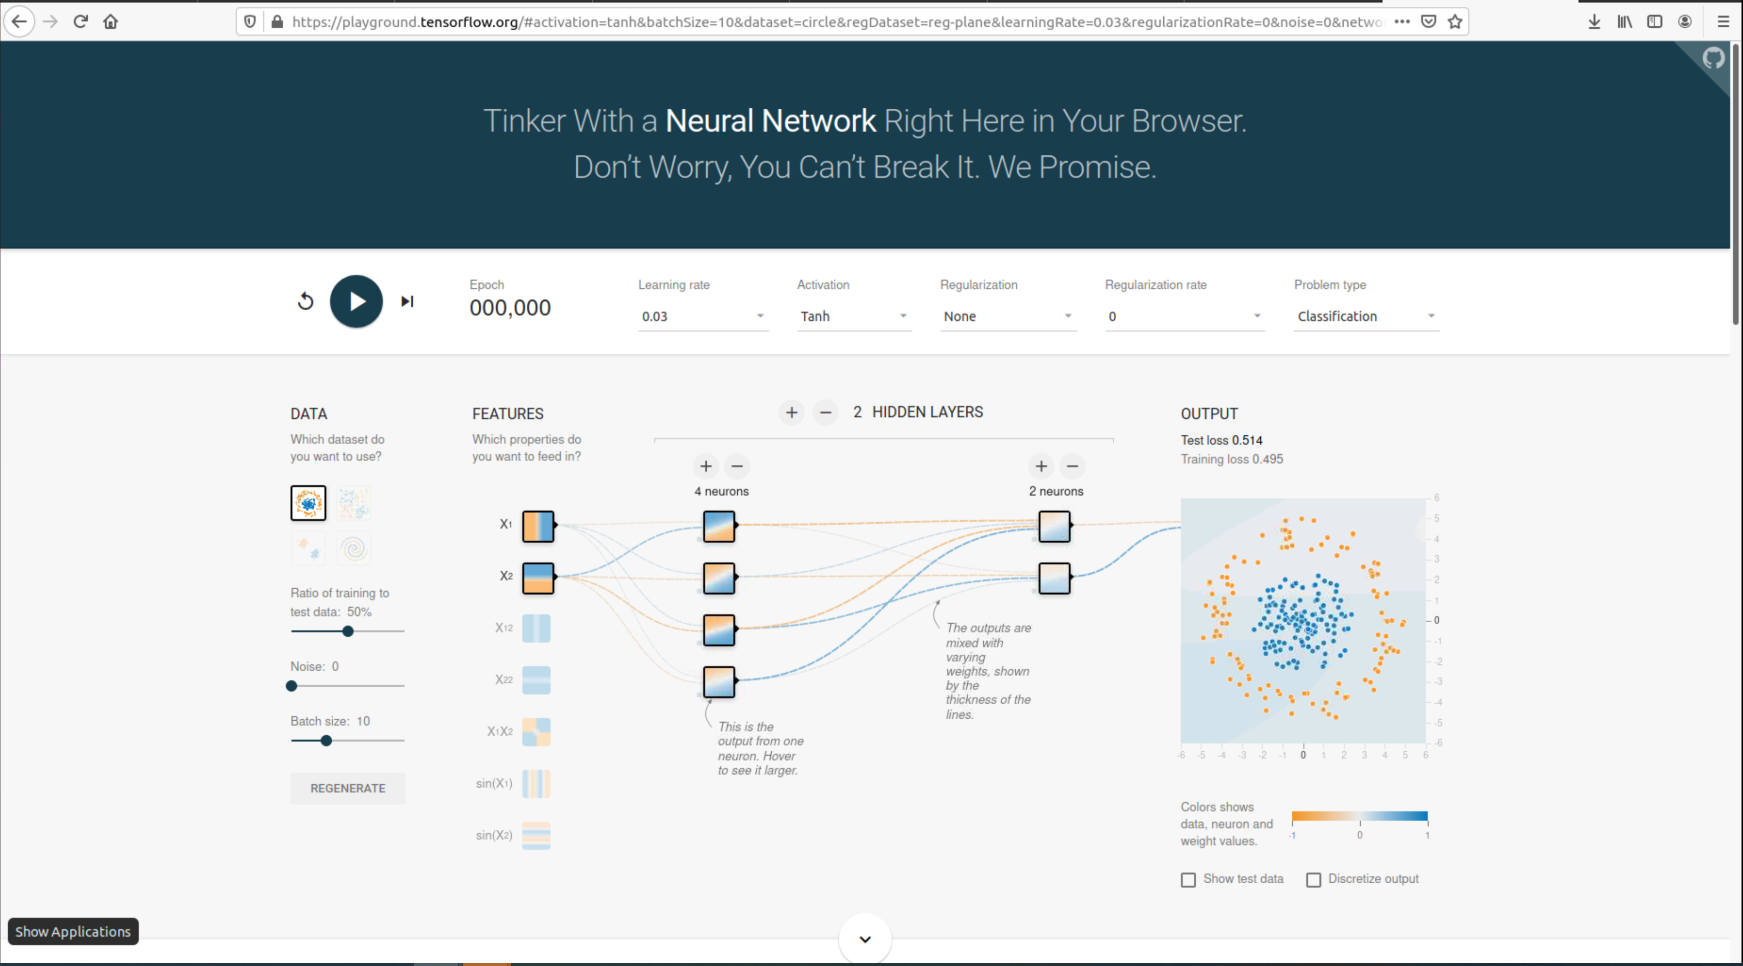

Set up a model with parameters (at the left) as:
- Ratio of training to test data: 90%
- Noise: 5
- Batch size: 4

Press "run" and observe the result. You can play around with the model.


## Exercise 1 (10 points)

In the Playground, select the spiral shape for the data
(the 4th shape). Set up parameters as follows.
- Ratio of training to test data: 90%
- Noise: 35
- Batch size: 4

Try to find a structure and parameters to find the best separation
between positive and negative cases. Capture a full screen result and input it in the next cell.

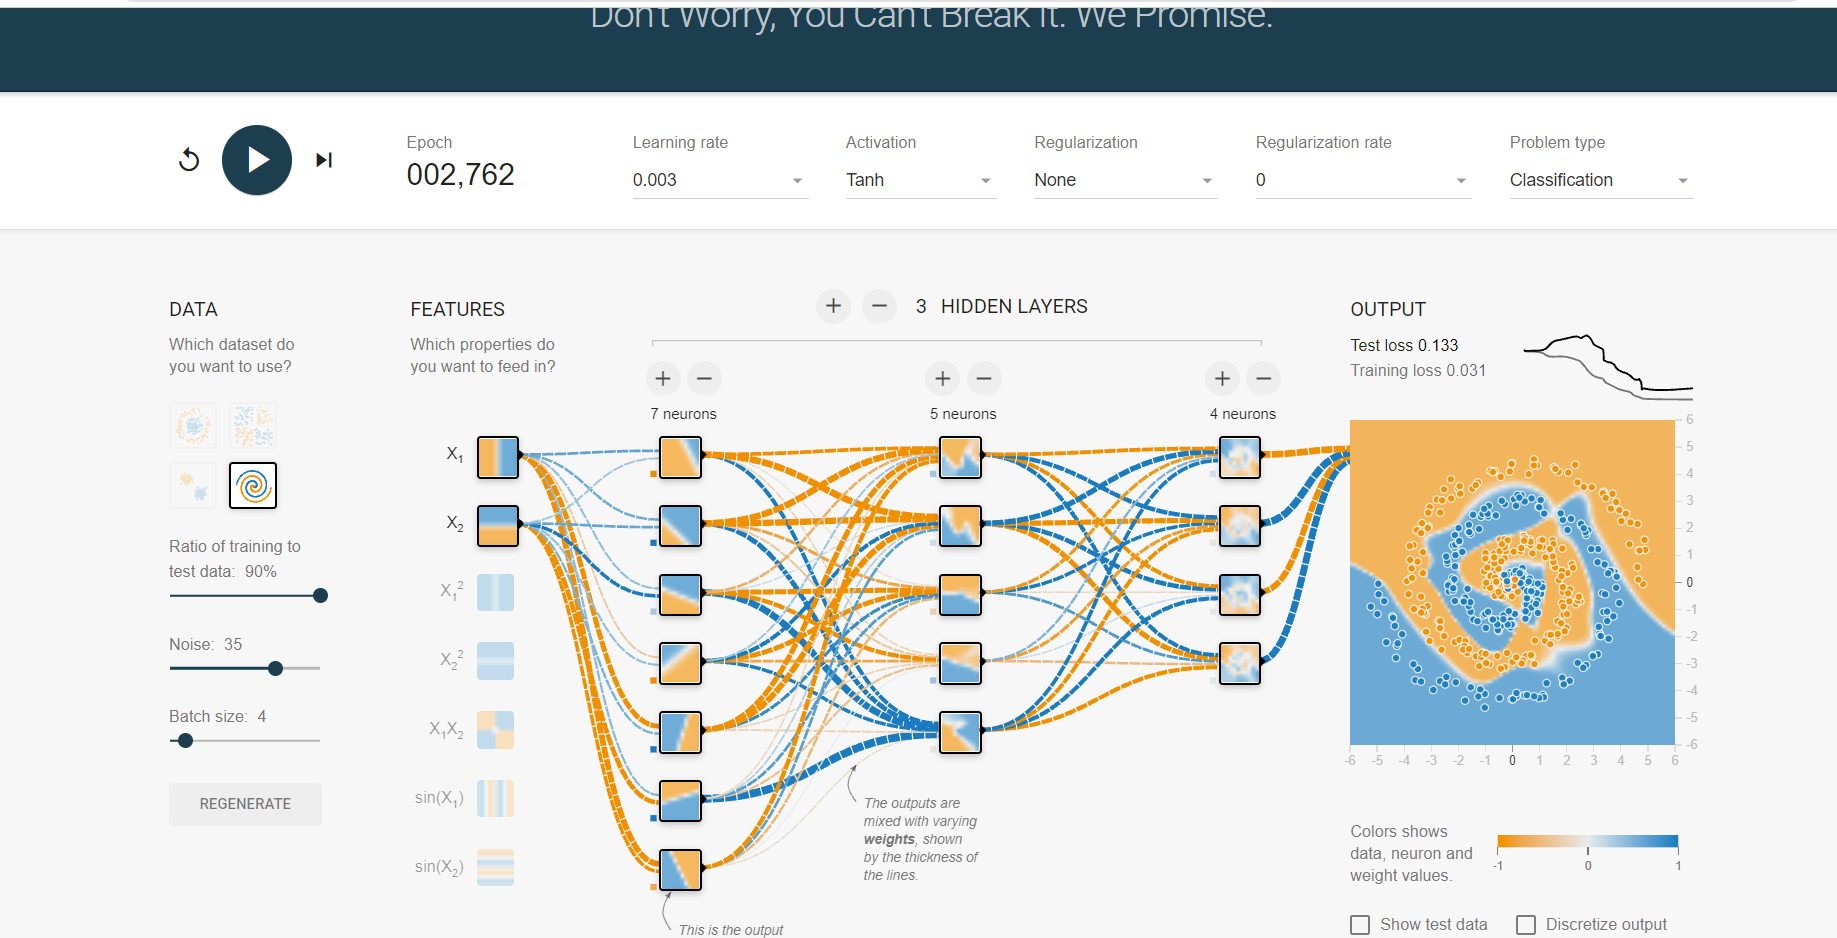

**Expected result**:

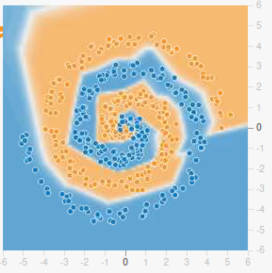

Let's make a GUI in Jupyter next (you GUI can also export to a HTML website).
Fix the settings to reflect what you did on the Playground.

In [546]:
from IPython.display import display, Markdown, clear_output

# Use the widget package
import ipywidgets as widgets

# Define some widgets
lblQ1 = widgets.Label(
        value="Q1) What is your learning rate?")
rdoQ1 = widgets.RadioButtons(
        options=['0.00001', '0.0001', '0.001', '0.003', '0.01', '0.03', '0.1', '0.3', '1', '3', '10',],
        value='0.03',
        description='\t',
        disabled=False)

lblQ2 = widgets.Label(
        value="Q2) What is your activation function in last layer?")
rdoQ2 = widgets.RadioButtons(
        options=['ReLu', 'Tanh', 'Sigmoid', 'Linear',],
        value='Tanh',
        description='\t',
        disabled=False)

lblQ3 = widgets.Label(
        value="Q3) What is problem type?")
rdoQ3 = widgets.RadioButtons(
        options=['Classification', 'Regression'],
        value='Classification',
        description='\t',
        disabled=False)

lblQ4 = widgets.Label(value="Q4) Which input do you use?")
chkQ4_1 = widgets.Checkbox(
           description='$X_1$',
           value=True)
chkQ4_2 = widgets.Checkbox(
           description='$X_2$',
           value=True)
chkQ4_3 = widgets.Checkbox(
           description='$X_1^2$',)
chkQ4_4 = widgets.Checkbox(
           description='$X_1X_2$',)
chkQ4_5 = widgets.Checkbox(
           description='$X_2^2$',)
chkQ4_6 = widgets.Checkbox(
           description='sin$(X_1)$',)
chkQ4_7 = widgets.Checkbox(
           description='sin$(X_2)$',)
chkQ4 = widgets.VBox([chkQ4_1, chkQ4_2, chkQ4_3, chkQ4_4, chkQ4_5, chkQ4_6, chkQ4_7])

lblQ5 = widgets.Label(value="Q5) How many hidden layers do you use?")
txtQ5 = widgets.IntText(
       value=0,
       description='hidden layers', )

lblQ6 = widgets.Label(value="Q6) Explain your nodes for each layer")
txtQ6 = widgets.Textarea(
       value='',
       description='Explain here', )

box = widgets.VBox([lblQ1, rdoQ1, lblQ2, rdoQ2, lblQ3, rdoQ3, lblQ4, chkQ4, lblQ5, txtQ5, lblQ6, txtQ6,])

box

In [547]:
q4str = ""
if chkQ4_1.value:
    q4str += " X1,"
if chkQ4_2.value:
    q4str += " X2,"
if chkQ4_3.value:
    q4str += " X1^2,"
if chkQ4_4.value:
    q4str += " X1X2,"
if chkQ4_5.value:
    q4str += " X2^2,"
if chkQ4_6.value:
    q4str += " sin(X1),"
if chkQ4_7.value:
    q4str += " sin(X2),"
print("Use input features:", q4str)
print("Problem type:", rdoQ3.value)
print("The last activation function:", rdoQ2.value)
print("Learning rate:", rdoQ1.value)
print("Use", txtQ5.value, "hidden layers. Each layer contains", txtQ6.value)

Use input features:  X1, X2,
Problem type: Classification
The last activation function: Tanh
Learning rate: 0.03
Use 0 hidden layers. Each layer contains 


## MNIST data set

An image is a 2D array of pixels. Pixels can be scalar intensities (for a grayscale / black and white image) or
a vector indicating a point in a color space such as RGB or HSV.

Today we'll consider 8$\times$8 grayscale images of digits from the famous "MNIST" dataset, which was considered
a benchmark for machine learning algorithms up to the early 2000s, before the advent of large-scale image
classification datasets.

MNIST is part of the SciKit-Learn module and has 10 classes,
with 180 samples per class in most cases, for a total of 1797 samples.

Let's load the dataset and plot an example.

[0 1 2 ... 8 9 8]
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


Text(0.5, 1.0, 'Example MNIST sample (category 0)')

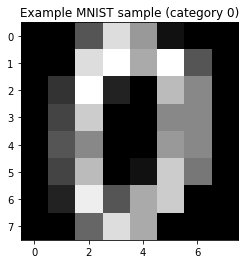

In [548]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# Load data

data = load_digits()
print(data.target)
def convert_to_one_hot(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, int(y[i])] = 1
    return y_vect

print(data.data)

# Convert target indices to one-hot representation

y_indices = data.target
y = convert_to_one_hot(y_indices)
X = np.matrix(data.data)
M = X.shape[0]
N = X.shape[1]

# Plot an example

plt.imshow(np.reshape(X[0,:],(8,8)), 'gray')
plt.title('Example MNIST sample (category %d)' % y_indices[0])

## Hand-Coded Fully Connected Neural Network

OK, now let's develop some code based on the mathematics we developed in
class to work with this dataset and run 100 epochs of training.
The main change is to use a one-hot encoding of the 10 classes at the output layer and to use
the softmax activation function at the output. Some minor changes are required to calculate multinomial
cross entropy loss rather than binary cross entropy loss.

First, some imports.

In [549]:
import random
import warnings
warnings.filterwarnings("ignore")

Next, let's normalize the input features using z-scaling (subtracting the mean of each input then dividing by
its standard deviation).

In [550]:
def normalize(X):
    M = X.shape[0]
    XX = X - np.tile(np.mean(X,0),[M,1])
    XX = np.divide(XX, np.tile(np.std(XX,0),[M,1]))
    return np.nan_to_num(XX, copy=True,nan=0.0)

XX = normalize(X)

Note that some researchers that do deep learning with
images use the word "normalization" to specifically indicate dividing
pixel intensities by 255 in order to scale them to the range 0..1. We use the more general
sense of the word "normalize," and we use the specific normalization technique of z-scaling.

Next we'll partition the data into separate training and test datasets.

In [551]:
idx = np.arange(0,M)

random.shuffle(idx)
percent_train = .6
m_train = int(M * percent_train)
train_idx = idx[:m_train]
test_idx = idx[m_train:]
X_train = XX[train_idx,:];
X_test = XX[test_idx,:];

y_train = y[train_idx];
y_test = y[test_idx];
y_test_indices = y_indices[test_idx]

Next, let's define a 3-layer network with sigmoid activation functions,
6 units in layer 1, and 5 units in layer 2.

In [552]:
h2 = 5
h1 = 6
W = [[], np.random.normal(0, 0.1, [N, h1]),
         np.random.normal(0, 0.1, [h1, h2]),
         np.random.normal(0, 0.1, [h2, 10])]
b = [[], np.random.normal(0, 0.1, [h1, 1]),
         np.random.normal(0, 0.1, [h2, 1]),
         np.random.normal(0, 0.1, [10, 1])]
L = len(W) - 1

Next, let's create some important functions used later.

In [553]:
def sigmoid_act(z):
    return 1 / (1 + np.exp(-z))

def softmax_act(z):
    exps = np.exp(z)
    return exps / np.sum(exps)

def sigmoid_actder(z):
    az = sigmoid_act(z)
    prod = np.multiply(az, 1 - az)
    return prod

def ff(x, W, b):
    L = len(W)-1
    a = x
    for l in range(1, L + 1):
        z = W[l].T * a + b[l]
        if (l == L):
            a = softmax_act(z)
        else:
            a = sigmoid_act(z)
    return a

def loss(y, yhat):
    return - np.dot(y, np.log(yhat))

def forward(x_this, W, b):
    L = len(W) - 1
    a = [x_this]
    z = [[]]
    delta = [[]]
    dW = [[]]
    db = [[]]
    for l in range(1, L + 1):
        z.append(W[l].T * a[l-1] + b[l])
        if (l == L):
            a.append(softmax_act(z[l]))
        else:
            a.append(sigmoid_act(z[l]))
        # Just to give arrays the right shape for the backprop step
        delta.append([]); dW.append([]); db.append([])
    return a, z, delta, dW, db

def back_propagation(y_this, a, z, W, delta, dW, db, show_check=False):
    '''
    Backprop step. Note that derivative of multinomial cross entropy
    loss is the same as that of binary cross entropy loss. See
    https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba
    for a nice derivation.
    '''
    L = len(W) - 1
    delta[L] = a[L] - np.matrix(y_this).T
    for l in range(L, 0, -1):
        db[l] = delta[l].copy()
        dW[l] = a[l-1] * delta[l].T
        if l > 1:
            delta[l-1] = np.multiply(sigmoid_actder(z[l-1]), W[l] * delta[l])

    # Check delta calculation

    if show_check:
        print('Target: %f' % y_this)
        print('y_hat: %f' % a[L][0, 0])
        print(db)
        y_pred = ff(x_this,W,b)
        diff = 1e-3
        W[1][10, 0] = W[1][10, 0] + diff
        y_pred_db = ff(x_this,W,b)
        L1 = loss(y_this, y_pred)
        L2 = loss(y_this, y_pred_db)
        db_finite_difference = (L2 - L1) / diff
        print('Original out %f, perturbed out %f' %
             (y_pred[0, 0], y_pred_db[0, 0]))
        print('Theoretical dW %f, calculated db %f' %
              (dW[1][10, 0], db_finite_difference[0, 0]))
    return dW, db

def update_step(W, b, dW, db, alpha):
    L = len(W) - 1
    for l in range(1, L + 1):            
        W[l] = W[l] - alpha * dW[l]
        b[l] = b[l] - alpha * db[l]
    return W, b

Now, let's train for 100 epochs with a mini-batch size of 1.

In [554]:
cost_arr = [] 

alpha = 0.01
max_iter = 100
for iter in range(0, max_iter):
    loss_this_iter = 0
    order = np.random.permutation(m_train)
    for i in range(0, m_train):
        
        # Grab the pattern order[i]
        
        x_this = X_train[order[i],:].T
        y_this = y_train[order[i],:]

        # Feed forward step
        a, z, delta, dW, db = forward(x_this, W, b)
            
        # calulate loss
        loss_this_pattern = loss(y_this, a[L])
        loss_this_iter = loss_this_iter + loss_this_pattern
        
        # back propagation
        dW, db = back_propagation(y_this, a, z, W, delta, dW, db, show_check=False)
        
        # update weight, bias
        W, b = update_step(W, b, dW, db, alpha)
            
    cost_arr.append(loss_this_iter[0,0])
    print('Epoch %d train loss %f' % (iter, loss_this_iter))

Epoch 0 train loss 2488.269250
Epoch 1 train loss 2486.685885
Epoch 2 train loss 2485.024292
Epoch 3 train loss 2482.605482
Epoch 4 train loss 2481.935573
Epoch 5 train loss 2478.696935
Epoch 6 train loss 2471.872758
Epoch 7 train loss 2456.609197
Epoch 8 train loss 2425.181907
Epoch 9 train loss 2357.438396
Epoch 10 train loss 2244.787326
Epoch 11 train loss 2127.243565
Epoch 12 train loss 2034.552016
Epoch 13 train loss 1974.210436
Epoch 14 train loss 1931.900616
Epoch 15 train loss 1902.210800
Epoch 16 train loss 1878.374813
Epoch 17 train loss 1859.043653
Epoch 18 train loss 1840.950145
Epoch 19 train loss 1820.476902
Epoch 20 train loss 1801.963026
Epoch 21 train loss 1779.412187
Epoch 22 train loss 1760.037411
Epoch 23 train loss 1735.951210
Epoch 24 train loss 1708.921566
Epoch 25 train loss 1679.198302
Epoch 26 train loss 1645.182734
Epoch 27 train loss 1610.192204
Epoch 28 train loss 1569.711727
Epoch 29 train loss 1529.879621
Epoch 30 train loss 1488.353160
Epoch 31 train los

Let's plot the loss over time per epoch.

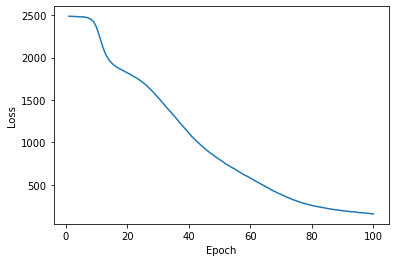

In [555]:
plt.plot(np.arange(1, max_iter + 1, 1), cost_arr)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Let's get the test set accuracy.

In [556]:
def predict_y(W, b, X):
    M = X.shape[0]
    y_pred = np.zeros(M)
    for i in range(X.shape[0]):
        y_pred[i] = np.argmax(ff(X[i, :].T, W, b))
    return y_pred

y_test_predicted = predict_y(W, b, X_test)
y_correct = y_test_predicted == y_test_indices
test_accuracy = np.sum(y_correct) / len(y_correct)

print('Test accuracy: %.4f' % (test_accuracy))

Test accuracy: 0.9166


## In-class exercise (40 points)

Modify the code above to plot both training loss and test loss as a function of epoch number.
Use early stopping to obtain the best model according to the validation set.
Experiment with the hyperparameters (learning rate, number of layers, number of units per layer) to get
the best result you can. In the cell below,
- Train with at least three different hyperparameter sets.
- Plot loss curves for the training and test sets on the same graph, with a legend showing the different
  hyperparameter settings.
- For each set of parameters, give the best validation accuracy.
- Describe your experiments and results below the code.

Epoch 1 train loss 2497.262069 , test loss 1665.963939
Epoch 2 train loss 2491.791608 , test loss 1659.791253
Epoch 3 train loss 2456.407540 , test loss 1558.542057
Epoch 4 train loss 2145.801954 , test loss 1302.894585
Epoch 5 train loss 1824.156122 , test loss 1092.705324
Epoch 6 train loss 1541.328922 , test loss 925.372918
Epoch 7 train loss 1327.555290 , test loss 798.223685
Epoch 8 train loss 1149.105261 , test loss 674.381562
Epoch 9 train loss 990.745092 , test loss 591.461381
Epoch 10 train loss 887.220624 , test loss 530.671538
Epoch 11 train loss 797.545528 , test loss 468.739963
Epoch 12 train loss 699.122919 , test loss 395.880130
Epoch 13 train loss 598.444783 , test loss 328.097508
Epoch 14 train loss 524.678778 , test loss 283.299516
Epoch 15 train loss 468.346959 , test loss 256.162359
Epoch 16 train loss 411.374463 , test loss 224.136623
Epoch 17 train loss 379.500480 , test loss 203.720437
Epoch 18 train loss 349.127043 , test loss 191.921212
Epoch 19 train loss 338.

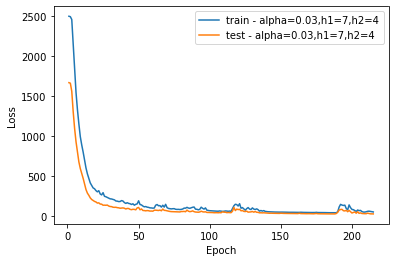

In [557]:
def loss_per_epoch(X , y, W, b):
    cost_arr = []
    m = X.shape[0]
    loss_this_iter = 0
    order = np.random.permutation(m)
    for i in range(0, m):

        # Grab the pattern order[i]

        x_this = X[order[i],:].T
        y_this = y[order[i],:]

        # Feed forward step
        a, z, delta, dW, db = forward(x_this, W, b)

        # calulate loss
        loss_this_pattern = loss(y_this, a[L])
        loss_this_iter = loss_this_iter + loss_this_pattern

        # back propagation
        dW, db = back_propagation(y_this, a, z, W, delta, dW, db, show_check=False)

        # update weight, bias
        W, b = update_step(W, b, dW, db, alpha)

    return loss_this_iter[0,0], W, b
     
    

#First hyperparameter set
h2 = 4
h1 = 7
W = [[], np.random.normal(0, 0.1, [N, h1]),
         np.random.normal(0, 0.1, [h1, h2]),
         np.random.normal(0, 0.1, [h2, 10])]
b = [[], np.random.normal(0, 0.1, [h1, 1]),
         np.random.normal(0, 0.1, [h2, 1]),
         np.random.normal(0, 0.1, [10, 1])]
L = len(W) - 1

# cost calculation for first hyperparameter set 
cost_arr_train = [] 
cost_arr_test = [] 

alpha = 0.03
best_test_loss = None
best_test_epoch = None
epoch = 1

while 1:
    train_loss_this_iter, W_train , b_train = loss_per_epoch(X_train, y_train, W, b)
    test_loss_this_iter, W_test, b_test = loss_per_epoch(X_test, y_test, W, b)
    cost_arr_train.append(train_loss_this_iter)
    cost_arr_test.append(test_loss_this_iter)
    if best_test_loss is None or test_loss_this_iter < best_test_loss:
        best_test_loss = test_loss_this_iter
        best_W = W_test.copy()
        best_b = b_test.copy()
        best_test_epoch = epoch
    print('Epoch %d train loss %f , test loss %f' % (epoch, train_loss_this_iter, test_loss_this_iter))
    if (epoch - best_test_epoch) > 30:
        print('Best loss at epoch %d, test loss %f' % (best_test_epoch, best_test_loss))
        break
    epoch += 1

#best validation set accuracy
def predict_y(W, b, X):
    M = X.shape[0]
    y_pred = np.zeros(M)
    for i in range(X.shape[0]):
        y_pred[i] = np.argmax(ff(X[i, :].T, W, b))
    return y_pred

y_test_predicted = predict_y(best_W, best_b, X_test)
y_correct = y_test_predicted == y_test_indices
test_accuracy = np.sum(y_correct) / len(y_correct)

print('Test accuracy: %.4f' % (test_accuracy))

#plotting both training loss and test loss as a function of epoch number

plt.plot(np.arange(1, epoch + 1, 1), cost_arr_train, label='train - alpha=0.03,h1=7,h2=4' )
plt.plot(np.arange(1, epoch + 1, 1), cost_arr_test, label='test - alpha=0.03,h1=7,h2=4')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Epoch 1 train loss 2519.649144 , test loss 1672.643287
Epoch 2 train loss 2508.675215 , test loss 1670.808749
Epoch 3 train loss 2502.289124 , test loss 1675.074344
Epoch 4 train loss 2506.050701 , test loss 1674.737330
Epoch 5 train loss 2502.514560 , test loss 1669.509416
Epoch 6 train loss 2458.723553 , test loss 1480.339419
Epoch 7 train loss 1988.034051 , test loss 1257.331807
Epoch 8 train loss 1800.679782 , test loss 1166.457084
Epoch 9 train loss 1620.252202 , test loss 1042.062561
Epoch 10 train loss 1461.602368 , test loss 954.301122
Epoch 11 train loss 1339.137175 , test loss 858.779194
Epoch 12 train loss 1224.319998 , test loss 799.121979
Epoch 13 train loss 1185.731724 , test loss 780.447691
Epoch 14 train loss 1083.591735 , test loss 739.062881
Epoch 15 train loss 1031.295284 , test loss 680.737902
Epoch 16 train loss 994.543282 , test loss 658.795903
Epoch 17 train loss 889.532043 , test loss 511.750434
Epoch 18 train loss 757.925319 , test loss 453.514804
Epoch 19 trai

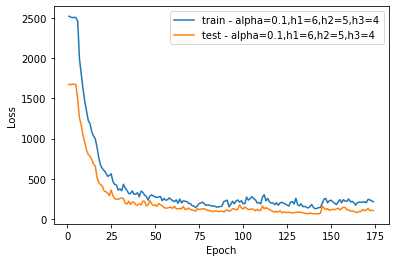

In [558]:
#Second hyperparameter set
h3 = 4
h2 = 5
h1 = 6
W = [[], np.random.normal(0, 0.1, [N, h1]),
         np.random.normal(0, 0.1, [h1, h2]),
         np.random.normal(0, 0.1, [h2, h3]),
         np.random.normal(0, 0.1, [h3, 10])]
b = [[], np.random.normal(0, 0.1, [h1, 1]),
         np.random.normal(0, 0.1, [h2, 1]),
         np.random.normal(0, 0.1, [h3, 1]),
         np.random.normal(0, 0.1, [10, 1])]
L = len(W) - 1

# cost calculation for first hyperparameter set 
cost_arr_train = [] 
cost_arr_test = [] 

alpha = 0.1
best_test_loss = None
best_test_epoch = None
epoch = 1

while 1:
    train_loss_this_iter, W_train , b_train = loss_per_epoch(X_train, y_train, W, b)
    test_loss_this_iter, W_test, b_test = loss_per_epoch(X_test, y_test, W, b)
    cost_arr_train.append(train_loss_this_iter)
    cost_arr_test.append(test_loss_this_iter)
    if best_test_loss is None or test_loss_this_iter < best_test_loss:
        best_test_loss = test_loss_this_iter
        best_W = W_test.copy()
        best_b = b_test.copy()
        best_test_epoch = epoch
    print('Epoch %d train loss %f , test loss %f' % (epoch, train_loss_this_iter, test_loss_this_iter))
    if (epoch - best_test_epoch) > 30:
        print('Best loss at epoch %d, test loss %f' % (best_test_epoch, best_test_loss))
        break
    epoch += 1

#best validation set accuracy
def predict_y(W, b, X):
    M = X.shape[0]
    y_pred = np.zeros(M)
    for i in range(X.shape[0]):
        y_pred[i] = np.argmax(ff(X[i, :].T, W, b))
    return y_pred

y_test_predicted = predict_y(best_W, best_b, X_test)
y_correct = y_test_predicted == y_test_indices
test_accuracy = np.sum(y_correct) / len(y_correct)

print('Test accuracy: %.4f' % (test_accuracy))

#plotting both training loss and test loss as a function of epoch number

plt.plot(np.arange(1, epoch + 1, 1), cost_arr_train, label='train - alpha=0.1,h1=6,h2=5,h3=4')
plt.plot(np.arange(1, epoch + 1, 1), cost_arr_test, label='test - alpha=0.1,h1=6,h2=5,h3=4')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Epoch 1 train loss 2221.215051 , test loss 922.479884
Epoch 2 train loss 862.653384 , test loss 473.006474
Epoch 3 train loss 668.716036 , test loss 298.483947
Epoch 4 train loss 524.149201 , test loss 273.586645
Epoch 5 train loss 469.201416 , test loss 288.501104
Epoch 6 train loss 414.327908 , test loss 269.849718
Epoch 7 train loss 451.694371 , test loss 218.747908
Epoch 8 train loss 423.137808 , test loss 217.118475
Epoch 9 train loss 426.708611 , test loss 238.764600
Epoch 10 train loss 372.326042 , test loss 202.006725
Epoch 11 train loss 338.275058 , test loss 168.964301
Epoch 12 train loss 350.785087 , test loss 213.349593
Epoch 13 train loss 347.328402 , test loss 170.146935
Epoch 14 train loss 348.907114 , test loss 188.626570
Epoch 15 train loss 357.809783 , test loss 199.182755
Epoch 16 train loss 308.282010 , test loss 145.279455
Epoch 17 train loss 288.601342 , test loss 137.223442
Epoch 18 train loss 277.181767 , test loss 122.854722
Epoch 19 train loss 312.175072 , tes

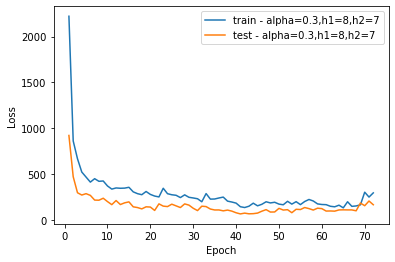

In [559]:
#Third hyperparameter set
h2 = 7
h1 = 8
W = [[], np.random.normal(0, 0.1, [N, h1]),
         np.random.normal(0, 0.1, [h1, h2]),
         np.random.normal(0, 0.1, [h2, 10])]
b = [[], np.random.normal(0, 0.1, [h1, 1]),
         np.random.normal(0, 0.1, [h2, 1]),
         np.random.normal(0, 0.1, [10, 1])]
L = len(W) - 1

# cost calculation for first hyperparameter set 
cost_arr_train = [] 
cost_arr_test = [] 

alpha = 0.3
best_test_loss = None
best_test_epoch = None
epoch = 1

while 1:
    train_loss_this_iter, W_train , b_train = loss_per_epoch(X_train, y_train, W, b)
    test_loss_this_iter, W_test, b_test = loss_per_epoch(X_test, y_test, W, b)
    cost_arr_train.append(train_loss_this_iter)
    cost_arr_test.append(test_loss_this_iter)
    if best_test_loss is None or test_loss_this_iter < best_test_loss:
        best_test_loss = test_loss_this_iter
        best_W = W_test.copy()
        best_b = b_test.copy()
        best_test_epoch = epoch
    print('Epoch %d train loss %f , test loss %f' % (epoch, train_loss_this_iter, test_loss_this_iter))
    if (epoch - best_test_epoch) > 30:
        print('Best loss at epoch %d, test loss %f' % (best_test_epoch, best_test_loss))
        break
    epoch += 1

#best validation set accuracy
def predict_y(W, b, X):
    M = X.shape[0]
    y_pred = np.zeros(M)
    for i in range(X.shape[0]):
        y_pred[i] = np.argmax(ff(X[i, :].T, W, b))
    return y_pred

y_test_predicted = predict_y(best_W, best_b, X_test)
y_correct = y_test_predicted == y_test_indices
test_accuracy = np.sum(y_correct) / len(y_correct)

print('Test accuracy: %.4f' % (test_accuracy))

#plotting both training loss and test loss as a function of epoch number

plt.plot(np.arange(1, epoch + 1, 1), cost_arr_train, label='train - alpha=0.3,h1=8,h2=7')
plt.plot(np.arange(1, epoch + 1, 1), cost_arr_test, label='test - alpha=0.3,h1=8,h2=7')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


The model for MNIST dataset was trained with 3 different set of hyperparameters. The first with 2 hidden layers (h1=7 and h2=4) and learning rate of 0.03. Second with 3 hidden layers(h1=6, h2=5, h3=4) and learning rate of 0.1. Final set with 2 hidden layers(h1=8,h2=7) and the learning rate of 0.3. 

When the model was trained with second hypermeter set that is with more complex model and higher learning rate, the loss curve converged faster. However, we can see some overfitting since the train cost reduces however test cost increases

When the model was trained with lower learning rate of 0.03, the loss curve was found to be smooth and best accuracy of the model was obtained.

## PyTorch tutorial

Is there an easier way to build this type of model? One way is to learn a framework such as TensorFlow or PyTorch. Both of these frameworks have their
pros and cons, but PyTorch is probably the most productive neural network framework for research purposes. We'll use it here.

The material for this tutorial is from
[Anand Saha's PyTorch tutorial](https://github.com/anandsaha/deep.learning.with.pytorch).

### Tensors and Tensor operations

Let's get some hands on experience with tensor creation and operations.
The torch package contains the necessary data structures to create multidimensional tensors.
It also defines the mathematical operations that can be performed on these.

In [560]:
import torch

print('Torch version:', torch.__version__)
print('Torch+CUDA working:', torch.cuda.is_available())

Torch version: 1.4.0
Torch+CUDA working: True


#### Tensor creation

Let's create a (2$\times$3) (two-dimensional) tensor.

Note that a) you get back a FloatTensor, and  b) the values are uninitialized.

In [561]:
t = torch.Tensor(2, 3)
print(t)

tensor([[ 6.7262e-44,  0.0000e+00,  6.7262e-44],
        [ 0.0000e+00, -1.5976e-10,  3.0941e-41]])


The above call was equivalent to

In [562]:
t = torch.FloatTensor(2, 3)
print(t)

tensor([[-1.2121e-01,  3.0941e-41, -1.5396e-05],
        [ 3.0941e-41,  8.9683e-44,  0.0000e+00]])


We can access an element, get an element's type, and get the shape of the tensor:

In [563]:
print('Elmement 0,0 of t:', t[0,0])
print('Type of element 0,0 of t:', type(t[0,0]))
print('Size of t:', t.size())
print('Number of dimensions in t:', t.dim())
print('A tensor\'s length is the number of dimensions it has?', len(t.size()) == t.dim())

Elmement 0,0 of t: tensor(-0.1212)
Type of element 0,0 of t: <class 'torch.Tensor'>
Size of t: torch.Size([2, 3])
Number of dimensions in t: 2
A tensor's length is the number of dimensions it has? True


Let's set some of the elements of the the tensor to various values:

In [564]:
t[0][0] = 1
t[0][1] = 2
t[0][2] = 3
t[1][0] = 4
t[1][1] = 5
t[1][2] = 6
print(t)

tensor([[1., 2., 3.],
        [4., 5., 6.]])


A `FloatTensor` can be cast to an `IntTensor`:

In [565]:
t = torch.FloatTensor([1.1, 2.2])
print('Float tensor:', t)
print('Int tensor:', t.type(torch.IntTensor))

Float tensor: tensor([1.1000, 2.2000])
Int tensor: tensor([1, 2], dtype=torch.int32)


Let's explore some other ways of creating a tensor.

In [566]:
# From another Tensor

t2 = torch.Tensor(t)
print('From a tensor:', t2)

# From a Python list

t3 = torch.IntTensor([[1, 2], [3, 4]])
print('From a Python list:', t3)

# From a NumPy array

import numpy as np
a = np.array([55, 66])
t4 = torch.Tensor(a)
print('From a NumPy array:', t4)

# A tensor with all zeros

t5 = torch.zeros(2, 3)
print('A tensor with all zeros:', t5)

# Create a tensor with all ones

t6 = torch.ones(2, 3)
print('A tensor with all ones:', t6)

# Create a tensor with all ones with dimensions 
# of another tensor

t7 = torch.ones_like(t4)
print('Another tensor of ones, with shape like another:', t7)

From a tensor: tensor([1.1000, 2.2000])
From a Python list: tensor([[1, 2],
        [3, 4]], dtype=torch.int32)
From a NumPy array: tensor([55., 66.])
A tensor with all zeros: tensor([[0., 0., 0.],
        [0., 0., 0.]])
A tensor with all ones: tensor([[1., 1., 1.],
        [1., 1., 1.]])
Another tensor of ones, with shape like another: tensor([1., 1.])


#### Tensor operations

Let's experiment with operations on tensors. We can add tensors of the same shape:

In [567]:
t1 = torch.ones(2, 2)
t2 = torch.ones(2, 2)
t = t1 + t2
print(t)

tensor([[2., 2.],
        [2., 2.]])


Here are some examples of in-place and out-of-place operations.

In [568]:
t1.add(t2)

tensor([[2., 2.],
        [2., 2.]])

In [569]:
print(t1)

tensor([[1., 1.],
        [1., 1.]])


In [570]:
t1.add_(t2)

tensor([[2., 2.],
        [2., 2.]])

In [571]:
print(t1)

tensor([[2., 2.],
        [2., 2.]])


Many operations are implemented as both instance methods and as library/package functions:

In [572]:
t1.cos()

tensor([[-0.4161, -0.4161],
        [-0.4161, -0.4161]])

In [573]:
torch.cos(t1)

tensor([[-0.4161, -0.4161],
        [-0.4161, -0.4161]])

A few more operations

In [574]:
# Create a one-dimensional tensor of steps equally 
# spaced points between start and end

torch.linspace(3, 10, steps=5)

tensor([ 3.0000,  4.7500,  6.5000,  8.2500, 10.0000])

In [575]:
# Create a 1-D Tensor with values from [start, end)

torch.arange(0, 5)

tensor([0, 1, 2, 3, 4])

In [576]:
# Create a (2x3) Tensor with random values sampled 
# from uniform distrubution on the interval [0,1)

torch.rand((2,3))

tensor([[0.4544, 0.7368, 0.6300],
        [0.5339, 0.5015, 0.4290]])

In [577]:
# Create a (2x3) Tensor with random values sampled 
# from normal distrubution with 0 mean and variance 1

torch.randn((2,3))

tensor([[-1.6116, -1.3621,  0.2462],
        [ 0.1409,  0.7215, -0.2602]])

In [578]:
# Do a matrix multiply

a = torch.rand((2, 3))
b = torch.rand((3, 2))

torch.mm(a, b)

tensor([[0.7480, 1.2057],
        [0.4789, 0.8352]])

#### Variables

Next, let's understand variables in PyTorch and the operations we can perform on them.

In [579]:
import torch
from torch.autograd import Variable

Let's create a small computation graph

In [580]:
x = Variable(torch.FloatTensor([11.2]), requires_grad=True)
y = 2 * x

In [581]:
print(x)
print(y)

tensor([11.2000], requires_grad=True)
tensor([22.4000], grad_fn=<MulBackward0>)


In [582]:
print(x.data)
print(y.data)

tensor([11.2000])
tensor([22.4000])


In [583]:
print(x.grad_fn)
print(y.grad_fn)

None


In [584]:
y.backward() # Calculates the gradients

In [585]:
print(x.grad)
print(y.grad)

tensor([2.])
None


### Working with PyTorch and NumPy

In [586]:
import torch
import numpy as np

Convert a NumPy array to Tensor

In [587]:
n = np.array([2, 3])
t = torch.from_numpy(n)
print(n)
print(t)

[2 3]
tensor([2, 3])


Change a Tensor value, and see the change in 
corresponding NumPy array

In [588]:
n[0] = 100
print(t)

tensor([100,   3])


Convert a Tensor to NumPy array

In [589]:
t = torch.FloatTensor([5, 6])
n = t.numpy()
print(t)
print(n)

tensor([5., 6.])
[5. 6.]


Change a Tensor value, and see the change in corresponding NumPy array

In [590]:
t[0] = 100
print(n)

[100.   6.]


### Tensors on GPU

Check if your machine has GPU support

In [591]:
if torch.cuda.is_available():
    print("GPU Supported")
else:
    print("GPU Not Supported")

GPU Supported


Check the number of GPUs attached to this machine

In [592]:
torch.cuda.device_count()

4

Get device name

In [593]:
torch.cuda.get_device_name(0)

'GeForce RTX 2080 Ti'

Moving a Tensor to GPU

In [594]:
t = torch.FloatTensor([2, 3])

In [595]:
print(t)

tensor([2., 3.])


In [596]:
t = t.cuda(0)

Creating a Tensor on GPU, directly

In [597]:
t = torch.cuda.FloatTensor([2, 3])
print(t)

tensor([2., 3.], device='cuda:0')


Bring it back to CPU

In [598]:
t = t.cpu()
print(t)

tensor([2., 3.])


Use device context

In [599]:
with torch.cuda.device(0):
    t = torch.cuda.FloatTensor([2, 3])
    print(t)

tensor([2., 3.], device='cuda:0')



## MNIST digit recognition using PyTorch

This part of the lab was
taken from the [Kaggle tutorial on MNIST with PyTorch]('https://www.kaggle.com/justuser/mnist-with-pytorch-fully-connected-network).

We will use a fully connected neural network and a batch learning algorithm and explain each
step along the way.

We need NumPy, PyTorch, some of PyTorch's modules, MatPlotLib, Seaborn for visualization, and pandas for
data import and transformations.

In [600]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Now we can import and transform the data. I decided to split it into input and labels right away at this step:

In [601]:
print("Reading the data...")
data = pd.read_csv('train_mnist.csv', sep=",")
test_data = pd.read_csv('test_mnist.csv', sep=",")

print("Reshaping the data...")
dataFinal = data.drop('label', axis=1)
labels = data['label']


dataNp = dataFinal.to_numpy()
labelsNp = labels.to_numpy()
test_dataNp = test_data.to_numpy()

print("Data is ready")

Reading the data...
Reshaping the data...
Data is ready


Now that data is ready, we can take a look at what we're dealing with. I will be using heatmaps from seaborn, which is an excellent tool for matrix visualization. But first, since the images in the MNIST dataset are represented as a long 1d arrays of pixels, we will need to reshape it into 2d array. That's where .reshape() from numpy comes in handy. The pictures are 28 x 28 pixels, so these will be the parameters.

Let's select a couple random samples and visualize them. I will also print their labels, so we can compare images with their actual value:

8  /  9
8  /  4
9  /  1


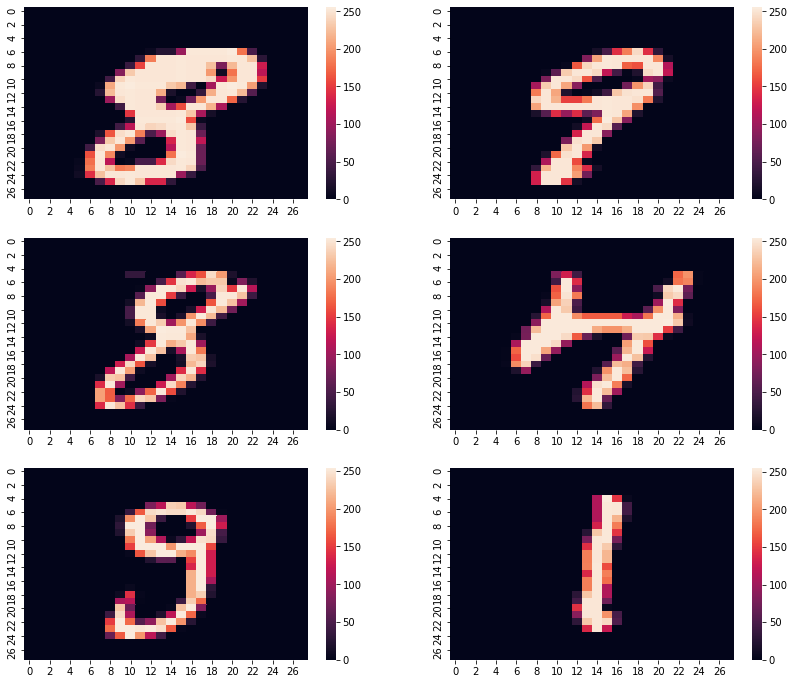

In [602]:
plt.figure(figsize=(14, 12))

pixels = dataNp[10].reshape(28, 28)
plt.subplot(321)
sns.heatmap(data=pixels)

pixels = dataNp[11].reshape(28, 28)
plt.subplot(322)
sns.heatmap(data=pixels)

pixels = dataNp[20].reshape(28, 28)
plt.subplot(323)
sns.heatmap(data=pixels)

pixels = dataNp[32].reshape(28, 28)
plt.subplot(324)
sns.heatmap(data=pixels)

pixels = dataNp[40].reshape(28, 28)
plt.subplot(325)
sns.heatmap(data=pixels)

pixels = dataNp[52].reshape(28, 28)
plt.subplot(326)
sns.heatmap(data=pixels)

print(labels[10], " / ", labels[11])
print(labels[20], " / ", labels[32])
print(labels[40], " / ", labels[52])

Since PyTorch uses tensors, we need to transform the input images
into tensors. The good news, as we saw earlier, is that PyTorch makes it very easy to move data from
NumPy arrays or regular Python lists to tensors. Here's how to do it for our data:

In [603]:
x = torch.FloatTensor(dataNp.tolist())
y = torch.LongTensor(labelsNp.tolist())
print(x)
print(y)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([1, 0, 1,  ..., 7, 6, 9])


Before we start writing the actual network, we need to determine what will be the hyperparameters. Those will not be adjusted during training, so we need to be careful how we set them up. 

Here's what we will specify:
* **input_size** - size of the input layer, it is always fixed (784 pixels)
* **output_size** - size of the output layer, also fixed size (10 for every possible digit)
* **hidden_size** - size of the hidden layer, this parameter determines structure of the network. 200 worked for me, but it is worth to play with this parameter to see what works for you
* **epochs** - how many times will the network go through the entire dataset during training. 
* **learning_rate** - determines how fast will the network learn. You should be very careful about this parameter, because if it is too high, the network won't learn at all, if it is too low, the net will learn too long. I's always about balance. Usualy 10^-3 - 10^-5 works just fine.
* **batch_size** - size of mini batches during training

In [604]:
# hyperparameters
input_size = 784
output_size = 10
hidden_size = 200

epochs = 20
batch_size = 50
learning_rate = 0.00005

Now we can finally write a Python class for the actual network.
Our `Network` class will be a subclass of PyTorch's neural network
`Module` class.

When writing a PyTorch neural network class, a few things must always be there:
* `__init__(self)`: initializes the the new `Network` instance. Here we set up instance fields
  representing the parameters of the network as well as any other needed initialization.
* `forward(self, x)`: defines how an input is propagated forward through the various layers
  and transformations in the network. The forward function normally makes use of the instance
  fields set up in the initialization stage.

In the initialization, first of all, we need to initialize the superclass's fields then
create needed layers with parameters. You can experiment with this (put more layers or change hidden layer size, etc.), but the give structure will work fine.

In forward propagation, we simply reassign the value of `x` as it flows through the layers
and return the softmax of the last linear layer's values at the end.

In [605]:
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l3(x)
        return F.log_softmax(x)

After we've defined the network, we can initialize it. 
Also, if we "print" the instance of the net, we can see the structure of it in a neat format:

In [606]:
net = Network()
print(net)

Network(
  (l1): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (l3): Linear(in_features=200, out_features=10, bias=True)
)


Now it's time to set up the [optimizer](http://pytorch.org/docs/master/optim.html) and a loss function. 

*There are quite a lot of things happening behind these two lines of code, so if you don't know what is going on here, don't worry too much for now, it will get clearer eventualy.* 

Optimizer is what  updates the parameters of the network. We'll use the most basic method, stochastic gradient descent with momentum. Also, the optimizer takes the network parameters as an argument, but it's not a big deal since we can get those with a `parameters()` method call on the network instance.

As is standard for a multinomial output distribution, we use [cross entropy loss](https://en.wikipedia.org/wiki/Cross_entropy).

In [607]:
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

Now that everything is ready, our network can start learning. I will separate data into minibatches and feed it to the network. It has many advantages over single batch learning, but that is a different story. 

Also, I will use loss_log list to keep track of the loss function during the training process. 

In [608]:
loss_log = []

for e in range(epochs):
    for i in range(0, x.shape[0], batch_size):
        x_mini = x[i:i + batch_size] 
        y_mini = y[i:i + batch_size] 
        
        x_var = Variable(x_mini)
        y_var = Variable(y_mini)
        
        optimizer.zero_grad()
        net_out = net(x_var)
        
        loss = loss_func(net_out, y_var)
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            loss_log.append(loss.item())
        
    print('Epoch: {} - Loss: {:.6f}'.format(e, loss.item()))

Epoch: 0 - Loss: 0.105932
Epoch: 1 - Loss: 0.066309
Epoch: 2 - Loss: 0.045226
Epoch: 3 - Loss: 0.044005
Epoch: 4 - Loss: 0.023051
Epoch: 5 - Loss: 0.020075
Epoch: 6 - Loss: 0.015947
Epoch: 7 - Loss: 0.014807
Epoch: 8 - Loss: 0.010584
Epoch: 9 - Loss: 0.010404
Epoch: 10 - Loss: 0.009896
Epoch: 11 - Loss: 0.009804
Epoch: 12 - Loss: 0.009686
Epoch: 13 - Loss: 0.008313
Epoch: 14 - Loss: 0.007920
Epoch: 15 - Loss: 0.007533
Epoch: 16 - Loss: 0.006944
Epoch: 17 - Loss: 0.006382
Epoch: 18 - Loss: 0.006482
Epoch: 19 - Loss: 0.005787


So, let's go line by line and see what is happening here:

This is the main loop that goes through all the epochs of training. An epoch is one full training on the full dataset.

    for e in range(epochs):
This is the inner loop that simply goes through the dataset batch by batch:

    for i in range(0, x.shape[0], batch_size):
Here is where we get the batches out of our data and simply assign them to variables for further work:

    x_mini = x[i:i + batch_size] 
    y_mini = y[i:i + batch_size] 
   These two lines are quite *important*. Remember I told you about tensors and how PyTorch stores data in them? That's not the end of story. Actually, to allow the network to work with data, we need a wrapper for those tensors called Variable. It has some additional properties, like allowing automatic gradient computation when backpropagating. It is required for the proper work of PyTorch, so we will add them here and supply tensors as parameters:
   
    x_var = Variable(x_mini)
    y_var = Variable(y_mini)
This line just resets the gradient of the optimizer:
    
    optimizer.zero_grad()
Remember the *forward(self, x)* function that we previously defined? The next line is basically calling this function and does the forward propagation:

    net_out = net(x_var)
This line computes the loss function based on predictions of the net and the correct answers:

    loss = loss_func(net_out, y_var)
Here we compute the gradient based on the loss that we've got. It will be used to adjust parameters of the network.

    loss.backward()
And here is where we finally update our network with new adjusted parameters:

    optimizer.step()
The rest is just logging, which might be helpful to observe how well the network is performing.

After the network is done with training, we can take a look at the loss function, and how it behaved during training:

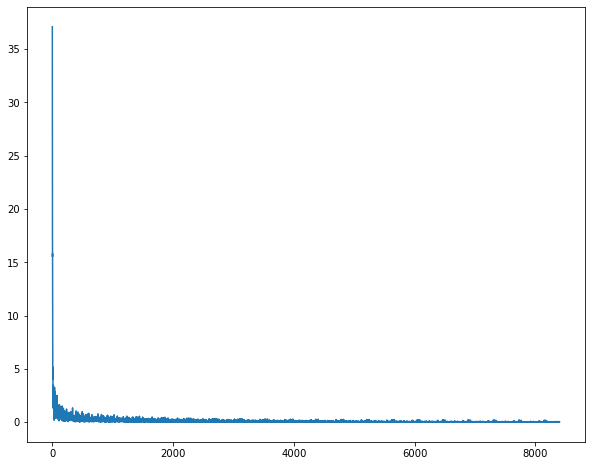

In [609]:
plt.figure(figsize=(10,8))
plt.plot(loss_log)

At this point, the network should be trained, and we can make a prediction using the test dataset. All we need to do is wrap the data into the Variable and feed it to the trained net, so nothing new here.

In [610]:
test = torch.FloatTensor(test_dataNp.tolist())
test_var = Variable(test)

net_out = net(test_var)

print(torch.max(net_out.data, 1)[1].numpy())

[2 0 9 ... 3 9 2]


Now we have out predictions that are ready to be submitted. Before that, we can take a look at predictions and compare them to the actual pictures of digits, just like at the start with training data:

Prediction: 0 / 5
Prediction: 9 / 7
Prediction: 0 / 8


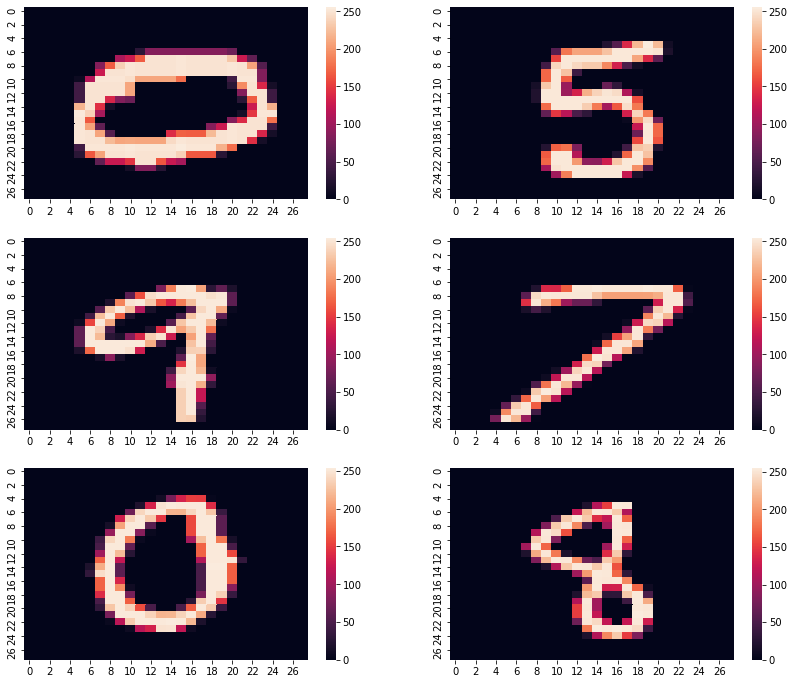

In [611]:
plt.figure(figsize=(14, 12))

pixels = test_dataNp[1].reshape(28, 28)
plt.subplot(321)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[1].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[10].reshape(28, 28)
plt.subplot(322)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[10].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[20].reshape(28, 28)
plt.subplot(323)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[20].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[30].reshape(28, 28)
plt.subplot(324)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[30].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[100].reshape(28, 28)
plt.subplot(325)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[100].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

pixels = test_dataNp[2000].reshape(28, 28)
plt.subplot(326)
sns.heatmap(data=pixels)
test_sample = torch.FloatTensor(test_dataNp[1].tolist())
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)


print("Prediction: {} / {}".format(torch.max(net_out.data, 1)[1].numpy()[1], torch.max(net_out.data, 1)[1].numpy()[10]))
print("Prediction: {} / {}".format(torch.max(net_out.data, 1)[1].numpy()[20], torch.max(net_out.data, 1)[1].numpy()[30]))
print("Prediction: {} / {}".format(torch.max(net_out.data, 1)[1].numpy()[100], torch.max(net_out.data, 1)[1].numpy()[2000]))

In [612]:
output = (torch.max(net_out.data, 1)[1]).numpy()
#np.savetxt("out.csv", np.dstack((np.arange(1, output.size+1),output))[0],"%d,%d",header="ImageId,Label")

And that is about it, we've made a simple neural network using PyTorch that can recognize handwritten digits. Not so bad!

When I was writing this notebook, this model scorred 96.6%, which is not perfect by any means, but it's not that bad either. 

I hope this was useful for some of you. If you are totally new to deep learning, I suggest you learn how the neural networks actually work from the inside, especially the backpropagation algorithm.

These videos explain [neural nets](https://www.youtube.com/watch?v=aircAruvnKk&t=708s) and [backpropagation](https://www.youtube.com/watch?v=Ilg3gGewQ5U) quite well.

Also I suggest you to take a look at this [online book](http://neuralnetworksanddeeplearning.com/chap1.html) (it's absolutely free, btw), where neural networks are explained in great detail, and it even has an implementation of the MNIST problem from scratch, using only numpy.

If you have any feedback, feel free to leave comments down below, and good luck with your deep learning adventures :)

## Take-home exercise (50 points)

Make sure you can run the PyTorch examples of MNIST classification, then apply the PyTorch example to another
classification problem you've worked with this semester, the breast cancer dataset. Get familiar with
working with models in PyTorch, get the best result you can on the breast cancer dataset, then 
report your experiments and results in your brief lab report.

In [613]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("breast_cancer.csv")
print(data.columns)

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')


In [614]:
X = data.drop(columns=['id','Unnamed: 32','diagnosis'])
y = data['diagnosis']
y, unique_y = pd.factorize(y)
X_columns = X.columns

X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

In [615]:
# Your code here

input_size = X_train.shape[1]
output_size = 1
hidden1_size = 7
hidden2_size = 6
hidden3_size = 5
hidden4_size = 6

epochs = 100
batch_size = 1
learning_rate = 0.0003

In [616]:
x = X_train_tensor
y = torch.FloatTensor(y_train)

In [617]:
class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
        self.l1 = nn.Linear(input_size, hidden1_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu1 = nn.ReLU()
        self.l3 = nn.Linear(hidden2_size, hidden3_size)
        self.relu2 = nn.ReLU()
        self.l4 = nn.Linear(hidden3_size, hidden4_size)
        self.relu3 = nn.ReLU()
        self.l5 = nn.Linear(hidden4_size, output_size)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu1(x)
        x = self.l3(x)
        x = self.relu2(x)
        x = self.l4(x)
        x = self.relu3(x)
        x = self.l5(x)
        return F.sigmoid(x)

In [618]:
net = Network()
print(net)

Network(
  (l1): Linear(in_features=30, out_features=7, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=7, out_features=6, bias=True)
  (relu1): ReLU()
  (l3): Linear(in_features=6, out_features=5, bias=True)
  (relu2): ReLU()
  (l4): Linear(in_features=5, out_features=6, bias=True)
  (relu3): ReLU()
  (l5): Linear(in_features=6, out_features=1, bias=True)
)


In [619]:
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_func = nn.BCELoss()

In [620]:
loss_log = []

for e in range(epochs):
    for i in range(0, x.shape[0], batch_size):
        x_mini = x[i:i + batch_size] 
        y_mini = y[i:i + batch_size] 
        
        x_var = Variable(x_mini)
        y_var = Variable(y_mini)
        
        optimizer.zero_grad()
        net_out = net(x_var)
   
        loss = loss_func(net_out, y_var)
        loss.backward()
        optimizer.step()
        
        # because graph was too noisy
#         if i % 100 == 0:
    loss_log.append(loss.item())
        
    print('Epoch: {} - Loss: {:.6f}'.format(e, loss.item()))

Epoch: 0 - Loss: 0.535456
Epoch: 1 - Loss: 0.503077
Epoch: 2 - Loss: 0.480961
Epoch: 3 - Loss: 0.463598
Epoch: 4 - Loss: 0.446310
Epoch: 5 - Loss: 0.423503
Epoch: 6 - Loss: 0.384645
Epoch: 7 - Loss: 0.306345
Epoch: 8 - Loss: 0.172798
Epoch: 9 - Loss: 0.071056
Epoch: 10 - Loss: 0.035557
Epoch: 11 - Loss: 0.023861
Epoch: 12 - Loss: 0.018113
Epoch: 13 - Loss: 0.014198
Epoch: 14 - Loss: 0.011409
Epoch: 15 - Loss: 0.009802
Epoch: 16 - Loss: 0.008270
Epoch: 17 - Loss: 0.007257
Epoch: 18 - Loss: 0.006413
Epoch: 19 - Loss: 0.005525
Epoch: 20 - Loss: 0.005558
Epoch: 21 - Loss: 0.004886
Epoch: 22 - Loss: 0.004862
Epoch: 23 - Loss: 0.004854
Epoch: 24 - Loss: 0.004924
Epoch: 25 - Loss: 0.005087
Epoch: 26 - Loss: 0.005332
Epoch: 27 - Loss: 0.005386
Epoch: 28 - Loss: 0.005536
Epoch: 29 - Loss: 0.005797
Epoch: 30 - Loss: 0.006072
Epoch: 31 - Loss: 0.006727
Epoch: 32 - Loss: 0.007214
Epoch: 33 - Loss: 0.007290
Epoch: 34 - Loss: 0.007708
Epoch: 35 - Loss: 0.007930
Epoch: 36 - Loss: 0.008702
Epoch: 37 -

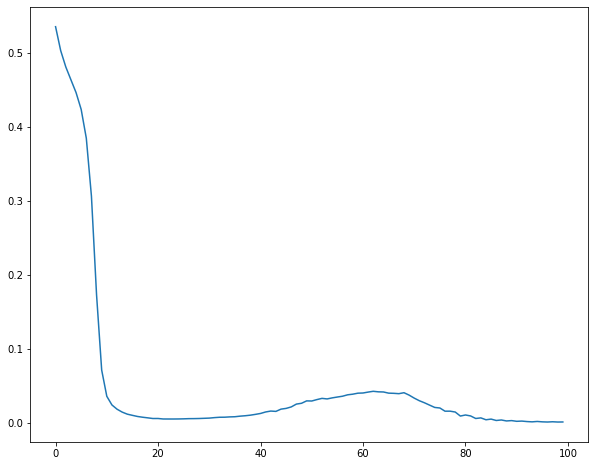

In [621]:
plt.figure(figsize=(10,8))
plt.plot(loss_log)

In [622]:
test_var = Variable(X_test_tensor)
net_out = net(test_var)

#to find the accuracy
y_pred = []
for i in net_out.data:
    if i>0.5:      
        y_pred.append(1)
    else:
        y_pred.append(0)


y_correct = y_pred == y_test
test_accuracy = np.sum(y_correct) / len(y_correct)
print('Test accuracy: %.4f' % (test_accuracy))

Test accuracy: 0.9825


For the take home exercise we used breast cancer dataset. Using pyTorch, a neural network consisting of 4 hidden layers was created. ReLu was used as activation function for each hidden layer and sigmoid was used for the output layer as the dataset was for binary classification. PyTorch framework simplified the implementation of neural network as it handled all the calcuations.

The model was trained for 100 epoch using batch size of 1 and learning rate of 0.003. Increasing the batch size increased the speed of training the model. However, the loss did not decrease significantly.

Binary cross Entropy loss function was used for this dataset as it was binary classification problem, classifying the output as malignant and benign.

Loss graph was plotted for the dataset and test set accuracy was calculated which was found around 97%.
